# Analyzing module-wise energies for different architectures

In [102]:
import sys
sys.path.append('../')

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils.data_utils import preprocess_and_normalize_energy_data
from torchvision import models
from utils.architecture_utils import get_modules_from_architecture
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
architectures_dict = {
    'alexnet': models.alexnet(weights=None),
    'vgg13': models.vgg13(weights=None),
    'vgg11': models.vgg11(weights=None),
    'vgg16': models.vgg16(weights=None)
}

# Loading and aggregating the data

In [105]:
df_unnormalized = pd.read_csv('../data/architectures-energies-2-parsed.csv')
df = preprocess_and_normalize_energy_data(
    df_unnormalized,
    ['module','batch_size','architecture','layer_idx'],
    aggregate=True,
    slurm_log_info=('../data/slurm-7520393.out','architectures'),
    num_repeat_config=3
)
df.head(n=10)

Dropped observations with the following indices: [68, 199, 259, 430, 450, 642, 661, 824, 882, 1109, 1200, 1387, 1561, 1571, 1747, 1930, 1999, 2116]
Final shape of data set: (707, 26)


,module,batch_size,architecture,layer_idx,Unnamed: 0,duration,emissions,emissions_rate,cpu_power,gpu_power,...,cloud_provider,cloud_region,cpu_count,gpu_count,longitude,latitude,ram_total_size,rep_no,macs,forward_passes
0,AlexNet,66,alexnet,0,1.0,30.210349,0.000969,0.032061,75.655877,30.460333,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,4.722709e+10,24.000000
1,Conv2d,66,alexnet,1,4.0,30.122630,0.000992,0.032920,75.321377,30.397667,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,4.651046e+09,207.666667
2,ReLU,66,alexnet,2,7.0,30.034931,0.000980,0.032642,79.948368,30.761000,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,1.277760e+07,8639.333333
3,MaxPool2d,66,alexnet,3,10.0,30.065253,0.000966,0.032138,75.563898,30.392000,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,1.385683e+07,417.000000
4,Conv2d,66,alexnet,4,13.0,30.185500,0.001015,0.033637,76.955921,30.091667,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,1.478986e+10,92.000000
5,ReLU,66,alexnet,5,16.0,30.035841,0.000976,0.032509,79.986591,30.105000,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,9.237888e+06,13123.666667
6,MaxPool2d,66,alexnet,6,19.0,30.060791,0.000964,0.032078,75.469942,30.108333,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,9.637056e+06,592.000000
7,Conv2d,66,alexnet,7,22.0,30.089101,0.000967,0.032129,76.201753,30.318000,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,7.405542e+09,195.333333
8,ReLU,66,alexnet,8,25.0,30.034411,0.000972,0.032365,78.856400,30.107000,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,4.283136e+06,38050.333333
9,Conv2d,66,alexnet,9,28.0,30.114219,0.000968,0.032136,76.522330,30.045333,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,9.871201e+09,147.000000


## Ensuring that module-wise observations are complete for every architecture and batch-size

In [106]:
for a in df.architecture.unique():
    sub = df.loc[df.architecture == a]
    num_modules_a = len(get_modules_from_architecture(architectures_dict[a]))
    for b in sub.batch_size.unique():
        sub_b = sub.loc[sub.batch_size == b]
        if num_modules_a+1 - len(sub_b) != 0:
            print(f"removing all observations from {a} with batch_size {b}")
            df = df.drop(index=sub_b.index)
print("Final data-shape: ", df.shape)

removing all observations from vgg13 with batch_size 143
Final data-shape:  (690, 26)


# Analysis

In [107]:
# compute % contribution
module_wise_contributions_by_architecture = pd.DataFrame(columns=['architecture','module','batch_size','cpu_energy','percent_contribution'])
for a in df.architecture.unique():
    # subset data by architecture
    sub = df.loc[df.architecture == a]
    total_measured_energies = []
    total_agg_energies = []
    for b in sub.batch_size.unique():
        # subset data by batch_size
        sub_b = sub.loc[sub.batch_size == b]
        # get energy from complete architecture run
        total_measured_energy = sub_b.loc[sub_b.layer_idx == 0].cpu_energy.item()
        # subset only data from individual modules of architecture
        sub_b = sub_b.loc[sub_b.layer_idx != 0]
        # compute empirical total energy from complete architecture run by summing up modules
        sub_b = sub_b.groupby(['architecture','batch_size','module'])['cpu_energy'].sum().reset_index()
        total_agg_energy = sum(sub_b.cpu_energy)
        # compute % contribution of module to total energy consumption
        sub_b["percent_contribution"] = round(sub_b.cpu_energy / total_agg_energy * 100, 2)
        module_wise_contributions_by_architecture = pd.concat([module_wise_contributions_by_architecture, sub_b], ignore_index=True)
        # store values
        total_agg_energies.append(total_agg_energy)
        total_measured_energies.append(total_measured_energy)
    # print avg energies; compare energy when running the full architecture vs summing the energy over the individual modules
    print(f"{a}: avg. total-measured-energy: {np.round(np.mean(total_measured_energies),10)}, avg. total-agg-energy: {np.round(np.mean(total_agg_energies),10)}, resulting deviation: {abs(np.round(np.mean([(b - a) / b for a, b in zip(total_measured_energies, total_agg_energies)]),2)*100)}%")

alexnet: avg. total-measured-energy: 4.94154e-05, avg. total-agg-energy: 4.96967e-05, resulting deviation: 0.0%
vgg11: avg. total-measured-energy: 0.0005424774, avg. total-agg-energy: 0.0005494098, resulting deviation: 1.0%
vgg13: avg. total-measured-energy: 0.00093645, avg. total-agg-energy: 0.0009428837, resulting deviation: 1.0%


# Plotting

black line shows deviations between batch-sizes


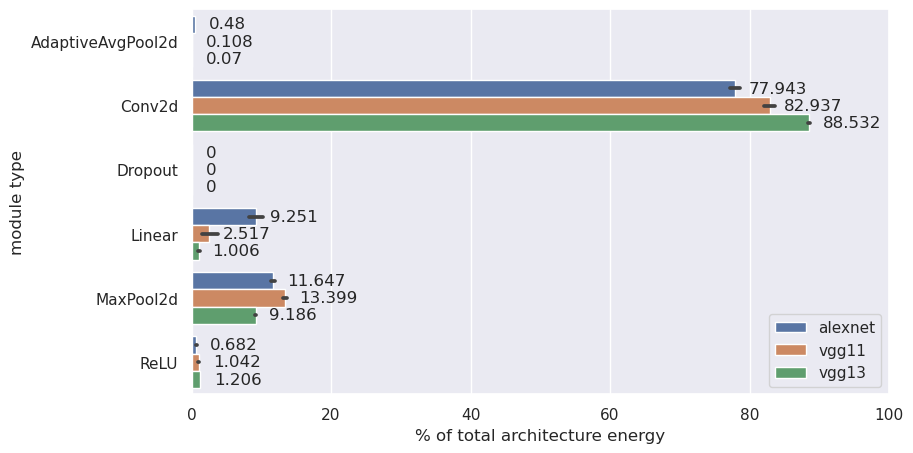

In [108]:
plt.figure(figsize=(9,5))
g = sns.barplot(data=module_wise_contributions_by_architecture, x="percent_contribution",y="module",hue="architecture")
for i in range(0,len(df.architecture.unique())):
    g.bar_label(g.containers[i], padding=10)

g.set_xlim(0, 100)
plt.legend(loc="lower right")
plt.ylabel("module type")
plt.xlabel("% of total architecture energy")
print("black line shows deviations between batch-sizes")

Text(0, 0.5, '% of total architecture energy')

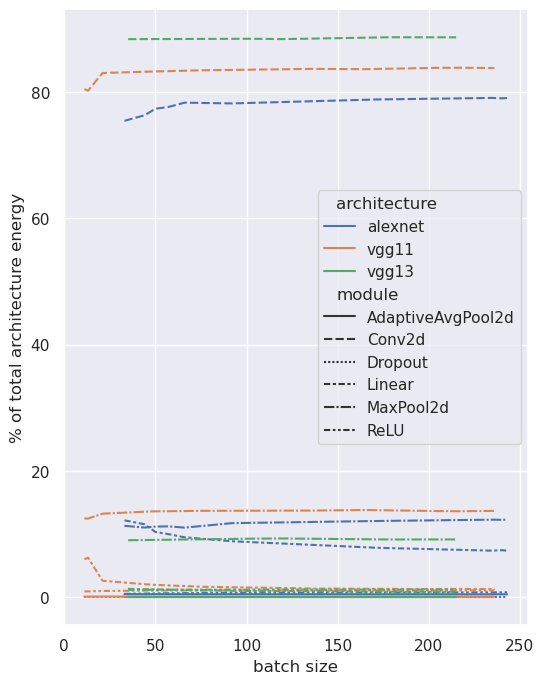

In [109]:
plt.figure(figsize=(6,8))
sns.lineplot(data=module_wise_contributions_by_architecture, x="batch_size", y="percent_contribution", hue="architecture",style="module")
plt.xlabel("batch size")
plt.ylabel("% of total architecture energy")